<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/Merge/merge_random%20select%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install mne

     |████████████████████████████████| 6.4MB 3.4MB/s 


In [2]:

import matplotlib

from matplotlib import pyplot as plt
import numpy as np

import math

import keras
from keras.utils import to_categorical

import random
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
#from mne.datasets import testing
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


Automatically created module for IPython interactive environment


In [42]:


Train_Data_number = 30000
Test_Data_number = 10000



subject_number=10

new_subject_number = subject_number//5 # 
#index_new_subject = 0

train_subject_number = subject_number - new_subject_number
new_subject_start_index = train_subject_number
task_index = [1] # task: REO
task_number = len(task_index)

# channels 
list_channel = [60]
ch_number = len(list_channel)

task_time = 60

sampel_number_per_sec = 160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160

inner_sample_shift = 5 # inner step len
outer_sample_shift = 20 # outer step len
window_len= 20

new_subject_start_index

8

In [43]:
# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_number
for x in range(subject_number):
    list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index)

list_rawdata = np.zeros((subject_number,task_number), dtype='object')

for i in range(subject_number):
    for j in range(task_number):
        list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S004/S004R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extr

In [44]:
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1

test_img_number = math.floor(subject_img_number * 0.15)
test_img_start_index=subject_img_number - test_img_number
train_img_number =  test_img_start_index 

test_img_start_index


398

In [0]:

def normalize_channel_data(ch , i, ch_min, ch_max):
    ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
    return ch

In [46]:
# All data
DataChannelsRaw = np.zeros((subject_number, ch_number,total_sampel_number), dtype = float)

for i in range(train_subject_number):
  for  j in range(ch_number):
    DataChannelsRaw[i][j], times =list_rawdata[i][0][list_channel[j],:total_sampel_number]
DataChannelsRaw_t = DataChannelsRaw.copy()

#normal all data
for i in range(subject_number):
  ch_max =[]
  ch_min =[]
  for  j in range(ch_number):    
    ch_max = np.append(ch_max, max(DataChannelsRaw_t[i][j])) # max for each cannel
    ch_min = np.append(ch_min, min(DataChannelsRaw_t[i][j])) # min for each cannel
    
    # Normalize Channels
    DataChannelsRaw_t[i][j]=normalize_channel_data(DataChannelsRaw_t[i][j], j, ch_min, ch_max)
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
DataChannelsRaw_t.shape

(10, 1, 9600)

In [0]:
def Extract_Data(rand_subject, rand_sample):

  Rand_Data =  np.zeros((ch_number, window_len, sampel_number_per_sec), dtype = float)
  for i in range(ch_number):
    for z in range (window_len):
      ExtractedData = DataChannelsRaw_t[rand_subject][i, rand_sample + z*inner_sample_shift: sampel_number_per_sec + rand_sample + z*inner_sample_shift] 
      Rand_Data[i][z] = ExtractedData
      
  return Rand_Data

In [0]:
def Fill_input_array(Data_number, first_index_subjectA, last_index_subjectA, first_index_sampleA, last_index_sampleA,   first_index_subjectB, last_index_subjectB, first_index_sampleB, last_index_sampleB):
  loop_counter = int(Data_number/2)
  
  input1 = np.zeros((Data_number, ch_number, window_len , sampel_number_per_sec), dtype = float)
  input2 = np.zeros((Data_number, ch_number, window_len, sampel_number_per_sec), dtype = float)
  input_label=[]
  
  for r in range(loop_counter):
    # select random subject and sample A
    rand_subjectA = random.randint(first_index_subjectA, last_index_subjectA)
    rand_sample1_A= random.randint(first_index_sampleA, last_index_sampleA) * outer_sample_shift
    rand_sample2_A= random.randint(first_index_sampleA, last_index_sampleA) * outer_sample_shift

    # 1: Select random data from subjectA 
    rand_Data1_subjectA = Extract_Data(rand_subjectA, rand_sample1_A)
    input1[r*2:r*2+2] = rand_Data1_subjectA

    # 2: Select random data from subjectA 
    rand_Data2_subjectA = Extract_Data(rand_subjectA, rand_sample2_A)
    input2[r*2] = rand_Data2_subjectA

    #set label 1
    input_label = np.append(input_label, 1) 



    # select random subject and sample B
    rand_sampleB= random.randint(first_index_sampleB, last_index_sampleB) * outer_sample_shift
    rand_subjectB = random.randint(first_index_subjectB, last_index_subjectB)
    # A != B
    while rand_subjectA == rand_subjectB:
      rand_subjectB = random.randint(first_index_subjectB, last_index_subjectB)

    # Select random data from subjectB
    rand_Data_subjectB = Extract_Data(rand_subjectB, rand_sampleB)
    input2[r*2+1] = rand_Data_subjectB

    #set label 0
    input_label = np.append(input_label, 0)
    
  return input1, input2, input_label


In [0]:
# **create Train Data 

Train_input1, Train_input2, train_label = Fill_input_array(Train_Data_number, 0, train_subject_number-1, 0, train_img_number-1, 0, train_subject_number-1, 0, train_img_number-1)

train_label = to_categorical(train_label, 2)


In [52]:
train_label

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [0]:
validation_index = math.floor( Train_Data_number * 0.2)


# validation & train

#train
x_train_1 =Train_input1[validation_index:]
x_train_2 =Train_input2[validation_index:]

y_train =train_label[validation_index:]

#validation
x_validation_1 =Train_input1[:validation_index]
x_validation_2 =Train_input2[:validation_index] 

y_valid =train_label[:validation_index]

#x_valid.shape

In [54]:

from keras import layers
from keras import models
from keras import regularizers
#from keras.layers import Dense, Merge
from keras.layers import *
from keras.models import Model


cnn1 = models.Sequential()
cnn1.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,sampel_number_per_sec), data_format= "channels_first" ))
print(cnn1.output.shape)
cnn1.add(layers.MaxPooling2D((2,2)))
print(cnn1.output.shape)
cnn1.add(layers.Conv2D(128, (3,3), activation = 'relu'))
print(cnn1.output.shape)
cnn1.add(layers.MaxPooling2D((2,2)))
print(cnn1.output.shape)
cnn1.add(layers.Conv2D(256, (3,3), activation = 'relu'))
print(cnn1.output.shape)
cnn1.add(layers.MaxPooling2D((2,2)))
cnn1.add(layers.Flatten())
print(cnn1.output.shape)


cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,sampel_number_per_sec), data_format= "channels_first" ))
print(cnn2.output.shape)
cnn2.add(layers.MaxPooling2D((2,2)))
print(cnn2.output.shape)
cnn2.add(layers.Conv2D(128, (3,3), activation = 'relu'))
print(cnn2.output.shape)
cnn2.add(layers.MaxPooling2D((2,2)))
print(cnn2.output.shape)
cnn2.add(layers.Conv2D(256, (3,3), activation = 'relu'))
print(cnn2.output.shape)
cnn2.add(layers.MaxPooling2D((2,2)))
cnn2.add(layers.Flatten())
print(cnn2.output.shape)

mergedOut = Concatenate()([cnn1.output,cnn2.output])

#mergedOut = Flatten()(mergedOut)    
mergedOut = Dense(512, activation='relu')(mergedOut)
mergedOut = Dropout(.5)(mergedOut)

# output layer
mergedOut = Dense(2, activation='sigmoid')(mergedOut)

newModel = Model([cnn1.input,cnn2.input], mergedOut)

#model = models.Sequential()
#model.add(layers.Concatenate([cnn1,cnn2]))
#model.add(layers.Dense(512, activation = 'relu'))
#model.add(layers.Dropout(0.5))
#print(model.output.shape)
#model.add(layers.Dense(2, activation = 'sigmoid'))
#print(model.output.shape)


from keras import optimizers

newModel.compile(loss= 'binary_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

(?, 64, 20, 160)
(?, 32, 10, 160)
(?, 30, 8, 128)
(?, 15, 4, 128)
(?, 13, 2, 256)
(?, ?)
(?, 64, 20, 160)
(?, 32, 10, 160)
(?, 30, 8, 128)
(?, 15, 4, 128)
(?, 13, 2, 256)
(?, ?)


In [55]:
history = newModel.fit(
        [x_train_1, x_train_2],
        y_train,
        epochs = 15,
        batch_size = 30,
        validation_data = ([x_validation_1, x_validation_2], y_valid)
)

Train on 24000 samples, validate on 6000 samples
Epoch 1/15
24000/24000 [==============================] - 30s 1ms/step - loss: 0.6850 - acc: 0.5290 - val_loss: 0.5860 - val_acc: 0.6111
Epoch 2/15
24000/24000 [==============================] - 27s 1ms/step - loss: 0.3099 - acc: 0.8663 - val_loss: 0.1919 - val_acc: 0.9222
Epoch 3/15
24000/24000 [==============================] - 27s 1ms/step - loss: 0.1940 - acc: 0.9175 - val_loss: 0.1566 - val_acc: 0.9386
Epoch 4/15
24000/24000 [==============================] - 27s 1ms/step - loss: 0.1607 - acc: 0.9329 - val_loss: 0.1238 - val_acc: 0.9472
Epoch 5/15
24000/24000 [==============================] - 27s 1ms/step - loss: 0.1293 - acc: 0.9502 - val_loss: 0.0964 - val_acc: 0.9647
Epoch 6/15
24000/24000 [==============================] - 27s 1ms/step - loss: 0.1129 - acc: 0.9584 - val_loss: 0.0821 - val_acc: 0.9754
Epoch 7/15
24000/24000 [==============================] - 27s 1ms/step - loss: 0.1018 - acc: 0.9637 - val_loss: 0.0771 - val_acc:

In [73]:
# **create Test Data 1 ( A : from train subject , B: from train subject ) 

test_input1, test_input2, test_label = Fill_input_array(Test_Data_number, 0, train_subject_number-1, test_img_start_index, subject_img_number-1, 0, train_subject_number-1, test_img_start_index, subject_img_number-1)

test_label = to_categorical(test_label, 2)
newModel.evaluate([test_input1, test_input2], test_label)

10000/10000 [==============================] - 5s 503us/step


[0.06542070447262377, 0.97785]

In [74]:
# **create Test Data 2 ( A : from train subject , B: from new subject ) 

test_input1, test_input2, test_label = Fill_input_array(Test_Data_number, 0, train_subject_number-1, test_img_start_index, subject_img_number-1, new_subject_start_index, subject_number-1, 0, subject_img_number-1)
test_label = to_categorical(test_label, 2)

newModel.evaluate([test_input1, test_input2], test_label)

10000/10000 [==============================] - 7s 701us/step


[0.09371985532604157, 0.957]

In [75]:
# **create Test Data 3 ( A : from new subject , B: from train subject ) 

test_input1, test_input2, test_label = Fill_input_array(Test_Data_number, new_subject_start_index, subject_number-1, 0, subject_img_number-1, 0, train_subject_number-1, test_img_start_index, subject_img_number-1)
test_label = to_categorical(test_label, 2)

newModel.evaluate([test_input1, test_input2], test_label)

10000/10000 [==============================] - 5s 526us/step


[0.5971478731155395, 0.8767]

In [76]:
# **create Test Data 4 ( A : from new subject , B: from new subject ) 

test_input1, test_input2, test_label = Fill_input_array(Test_Data_number, new_subject_start_index, subject_number-1, 0, subject_img_number-1, new_subject_start_index, subject_number-1, 0, subject_img_number-1)

test_label = to_categorical(test_label, 2)
newModel.evaluate([test_input1, test_input2], test_label)

10000/10000 [==============================] - 7s 652us/step


[0.698938250541687, 0.5]

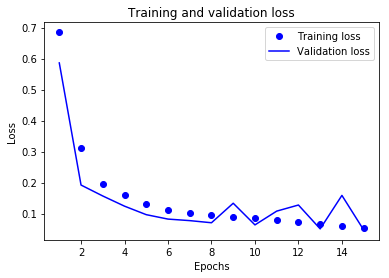

In [63]:
import matplotlib.pyplot as plt

history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.show()

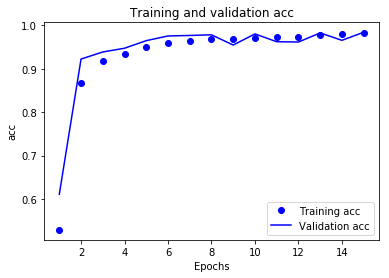

In [60]:
history_dict = history.history 
acc_values = history_dict ['acc'] 
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('acc') 
plt.legend()
plt.show()